# RAG Challenge - Retrieval Augmented Generation

## Step 1: Import necessary libraries and load the dataset

In [2]:
import pandas as pd
import numpy as np
import os
import kagglehub

### Load Dataset: Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

# Load dataset from downloaded path
dataset_path = f"{path}/Reviews.csv"
df = pd.read_csv(dataset_path, nrows=1000)  # Load a small subset of 1000 rows

# Output preview of dataset
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 2. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      1000 non-null   int64 
 1   ProductId               1000 non-null   object
 2   UserId                  1000 non-null   object
 3   ProfileName             1000 non-null   object
 4   HelpfulnessNumerator    1000 non-null   int64 
 5   HelpfulnessDenominator  1000 non-null   int64 
 6   Score                   1000 non-null   int64 
 7   Time                    1000 non-null   int64 
 8   Summary                 1000 non-null   object
 9   Text                    1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


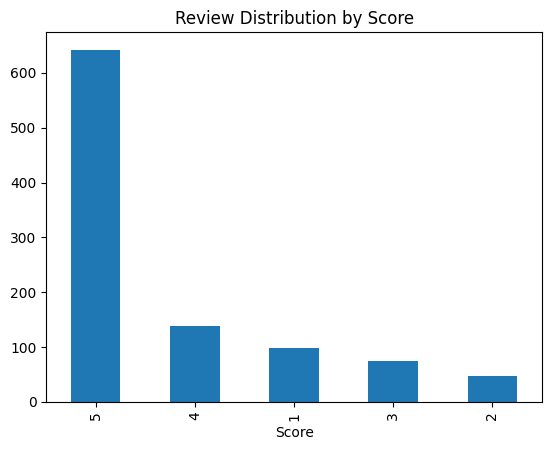

Missing Values: 
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


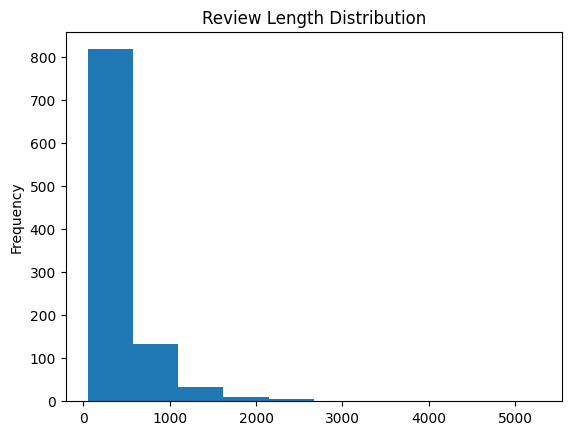

In [3]:
# General overview of dataset
df.info()

# Distribution of reviews by score
import matplotlib.pyplot as plt

df['Score'].value_counts().plot(kind='bar', title='Review Distribution by Score')
plt.show()

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values: \n{missing_values}")

# Understanding review length
df['review_length'] = df['Text'].apply(len)
df['review_length'].describe()

# Plot histogram of review length
df['review_length'].plot(kind='hist', title='Review Length Distribution')
plt.show()

## 3. Embedding and Storing Chunks

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

# Load embedding model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Split dataset into chunks (e.g., reviews)
chunks = df['Text'].tolist()

# Generate embeddings for each chunk
embeddings = embedding_model.encode(chunks)

# Output embedding size for first review
print("Embedding size:", len(embeddings[0]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding size: 384


## 4. Connecting to Vector Database

In [7]:
import chromadb

# Connect to ChromaDB client
chroma_client = chromadb.PersistentClient()

# Define the collection name
collection_name = 'product_review_embeddings'

# Create a collection in ChromaDB to store embeddings, if it doesn't already exist
try:
    collection = chroma_client.create_collection(name=collection_name)
except chromadb.errors.UniqueConstraintError:
    collection = chroma_client.get_collection(name=collection_name)

# Add embeddings to the collection
for i, embedding in enumerate(embeddings):
    collection.add(embeddings=[embedding.tolist()], metadatas=[{'content': chunks[i]}], ids=[str(i)])

## 5. Document Retrieval

In [8]:
# Test the retrieval logic
def retrieve_document(query, top_k=3):
    query_embedding = embedding_model.encode([query])
    results = collection.query(query_embeddings=query_embedding, n_results=top_k)
    return results

# Example query
query = "What do people think about the taste of this product?"
retrieved_docs = retrieve_document(query)
print("Top Retrieved Documents:\n", retrieved_docs)

Top Retrieved Documents:
 {'ids': [['887', '606', '948']], 'embeddings': None, 'documents': [[None, None, None]], 'uris': None, 'data': None, 'metadatas': [[{'content': 'Great taste. Great ingredients. Great texture. Absolutely delicious! They are a little smaller and you may still be hungry if it is for a meal. I give one to my 5 year old son for breakfast and he is still a little hungry for more. Either that or they taste so good he wants more.'}, {'content': "Tasted good. Spicy. Those that don't like spicy should stay away from this. For the price paid, very good buy."}, {'content': "Pretty good product.  The taste isn't the best but it's definitely not the worse either.  It gives a pretty smooth energetic kick."}]], 'distances': [[0.741456925868988, 0.7904287576675415, 0.82314133644104]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


## 6. Connecting to LLM

In [9]:
import openai
import pandas as pd
import numpy as np
import kagglehub
from sentence_transformers import SentenceTransformer
import chromadb

# Set up OpenAI API key
openai.api_key = "my-openai-api-key"
# 1. Dataset Selection
# Load Dataset using KaggleHub
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
dataset_path = f"{path}/Reviews.csv"
df = pd.read_csv(dataset_path, nrows=1000)

# 2. Load Embedding Model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# 3. Connect to ChromaDB and store embeddings
chroma_client = chroma_client = chromadb.PersistentClient()
collection_name = 'product_review_embeddings'

try:
    collection = chroma_client.create_collection(name=collection_name)
except chromadb.errors.UniqueConstraintError:
    collection = chroma_client.get_collection(name=collection_name)

chunks = df['Text'].tolist()
embeddings = embedding_model.encode(chunks)

for i, embedding in enumerate(embeddings):
    collection.add(embeddings=[embedding.tolist()], metadatas=[{'content': chunks[i]}], ids=[str(i)])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Define a sample query
query = "What do people think about the taste of this product?"

# Function to retrieve documents
def retrieve_document(query, top_k=3):
    query_embedding = embedding_model.encode([query])
    results = collection.query(query_embeddings=query_embedding, n_results=top_k)
    return results

# Retrieve relevant documents
retrieved_docs = retrieve_document(query)

# Develop logic to generate response based on retrieved documents
def generate_response(query, retrieved_docs):
    combined_input = f"Question: {query}\n\nRelevant Documents:\n"
    for doc_list in retrieved_docs['metadatas']:
        for metadata in doc_list:
            combined_input += f"- {metadata['content']}\n"

    # Generate response using the OpenAI Chat API
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": combined_input}
        ],
        max_tokens=100
    )
    return response['choices'][0]['message']['content']

# Example response generation
response = generate_response(query, retrieved_docs)
print(f"Generated Response: {response}")

Generated Response: Based on the feedback provided in the relevant documents, people generally have positive opinions about the taste of the product. Some describe it as absolutely delicious with great ingredients and texture. However, there are also mentions that it may be spicy, so those who do not like spicy flavors should be cautious. Overall, the general consensus seems to be that the taste is good, although not everyone may find it to be the best.


## 7. Evaluation

In [ ]:
# Create test set of queries
queries = [
    "What do customers say about the quality of the product?",
    "Are people happy with the price of this item?",
    "What are the complaints regarding the packaging?"
]

# Evaluate system performance manually
for q in queries:
    docs = retrieve_document(q)
    resp = generate_response(q, docs)
    print(f"Query: {q}\nGenerated Response: {resp}\n")

Query: What do customers say about the quality of the product?
Generated Response: Customers have provided mixed reviews about the product. Some customers have expressed disappointment in the quality, mentioning that it did not meet their expectations based on the company's reputation for excellent home delivery products and that it tasted like cheap thickened jelly. On the other hand, some customers found the product to be a cute stocking stuffer that arrived quickly but only rated it as okay in terms of user appeal, noting that you get what you pay for.

Query: Are people happy with the price of this item?
Generated Response: Overall, people seem to have mixed feelings about the price of the item. Some feel that the price is a great deal, as they mention that it is at least half the retail price and the quality is good. Others, however, feel that the price is a little high, especially when factoring in additional costs like shipping. It ultimately depends on individual preferences an

## 8. Conclusion


Successfully implemented a RAG system using embeddings, ChromaDB, and OpenAI API. The system retrieves relevant information and generates responses to user queries.

**Future Improvements:**
- Handle longer and more complex queries effectively.
- Experiment with multimodal datasets.